In [1]:
import pandas as pd
import numpy as np
import keras
from collections import defaultdict
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K

import os

%matplotlib inline
from sklearn.model_selection import train_test_split
import shutil

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import random
from tqdm import tqdm

In [2]:
#Preparing the data
def generateDataBasedOnNumberOfClass(src, dst,  symlinks = False, ignore = None,count=1,nclasses=3):
    if not os.path.exists(dst):
        os.makedirs(dst)
        shutil.copystat(src, dst)
    
    random.seed(100)
    lst = os.listdir(src)
    if(count==1):
        lst = random.sample(lst,nclasses)
    if ignore:
        excl = ignore(src, lst)
        lst = [x for x in lst if x not in excl]
    
        
    for item in lst:
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        
        if symlinks and os.path.islink(s):
            if os.path.lexists(d):
                os.remove(d)
            os.symlink(os.readlink(s), d)
            try:
                st = os.lstat(s)
                mode = stat.S_IMODE(st.st_mode)
                os.lchmod(d, mode)
            except:
                pass # lchmod not available
        elif os.path.isdir(s):
            generateDataBasedOnNumberOfClass(s, d, symlinks, ignore,count+1,nclasses)
        else:
            shutil.copy2(s, d)

def generate_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [l.strip() for l in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

train_dir_files = generate_dir_file_map('../input/food41/meta/meta/train.txt')
test_dir_files = generate_dir_file_map('../input/food41/meta/meta/test.txt')

def ignore_train(d, filenames):
    subdir = d.split('/')[-1]
    to_ignore = train_dir_files[subdir]
    return to_ignore

def ignore_test(d, filenames):
    #print(d)
    subdir = d.split('/')[-1]
    to_ignore = test_dir_files[subdir]
    return to_ignore

generateDataBasedOnNumberOfClass('../input/food41/images', './test',
                                 ignore=ignore_train,count=1,nclasses=3)
generateDataBasedOnNumberOfClass('../input/food41/images', './train',
                                 ignore=ignore_test,count=1,nclasses=3)

In [3]:
classtolabel ={}
for i in range(0,len(os.listdir("./test"))):
    classtolabel[i]=os.listdir("./test")[i]

In [4]:
#listing the 3 selected classes at random
classtolabel

{0: 'lasagna', 1: 'tiramisu', 2: 'carrot_cake'}

In [5]:
#performing data augmentation on train and test images
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) #rescale to [0-1], add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory(
        "./train",
        target_size=(224,224),
        batch_size=64)
test_datagen = ImageDataGenerator(rescale=1/255) # just rescale to [0-1] for testing set
test_generator = test_datagen.flow_from_directory(
        "./test",
        target_size=(224,224),
        batch_size=64)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [6]:
#preparing the model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, 
                 padding = 'Same', activation ='relu', input_shape = (224,224,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, 
                 padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

#callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [7]:
#creating the model
history = model.fit_generator(train_generator,steps_per_epoch=2250/64,
                              validation_data=test_generator,validation_steps=750/64, 
                              epochs=200, callbacks=[checkpointer, reduceLR, earlystopping])

Epoch 1/200
36/35 [==============================] - ETA: -1s - loss: 1.2589 - accuracy: 0.3324
Epoch 00001: val_loss improved from inf to 1.13580, saving model to model.hdf5
36/35 [==============================] - 73s 2s/step - loss: 1.2589 - accuracy: 0.3324 - val_loss: 1.1358 - val_accuracy: 0.3453
Epoch 2/200
36/35 [==============================] - ETA: -1s - loss: 1.0923 - accuracy: 0.4298
Epoch 00002: val_loss improved from 1.13580 to 1.01878, saving model to model.hdf5
36/35 [==============================] - 71s 2s/step - loss: 1.0923 - accuracy: 0.4298 - val_loss: 1.0188 - val_accuracy: 0.4960
Epoch 3/200
36/35 [==============================] - ETA: -1s - loss: 1.0474 - accuracy: 0.4747
Epoch 00003: val_loss improved from 1.01878 to 1.00729, saving model to model.hdf5
36/35 [==============================] - 72s 2s/step - loss: 1.0474 - accuracy: 0.4747 - val_loss: 1.0073 - val_accuracy: 0.5187
Epoch 4/200
36/35 [==============================] - ETA: -1s - loss: 1.0178 - a

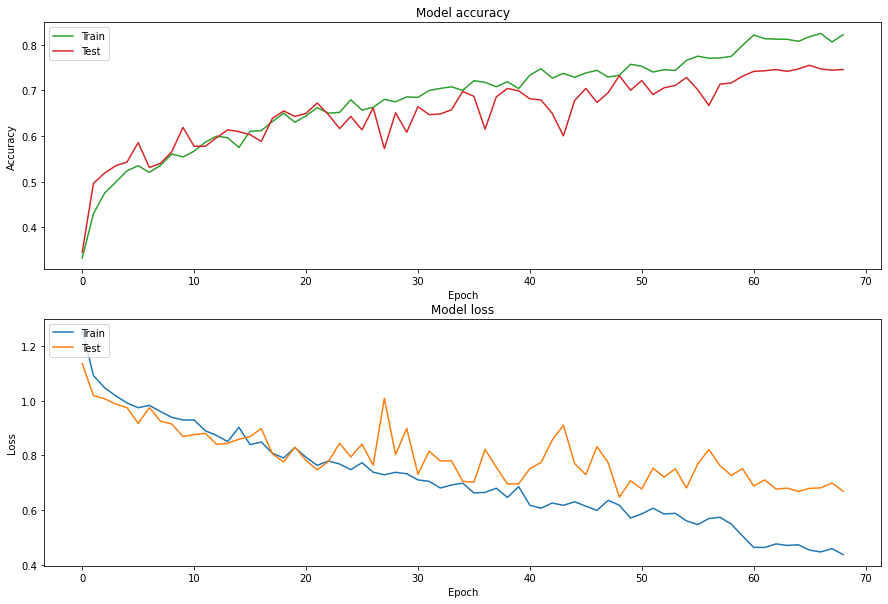

In [8]:
#plotting the observations
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

In [9]:
#Generation of image with ImageDataGenerator
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
        "./test/",
        target_size=(224,224),
        batch_size=64)

Found 750 images belonging to 3 classes.


In [10]:
#returning accuracy
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 76.6%


In [11]:
list(classtolabel.keys())

[0, 1, 2]

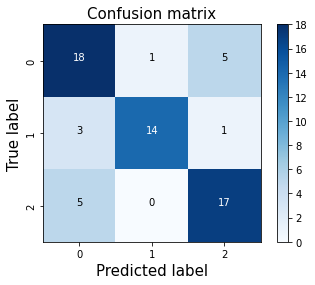

In [12]:
#plotting the graph
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = list(classtolabel.keys())
    plt.xticks([0,1,2], classes, fontsize=10)
    plt.yticks([0,1,2], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

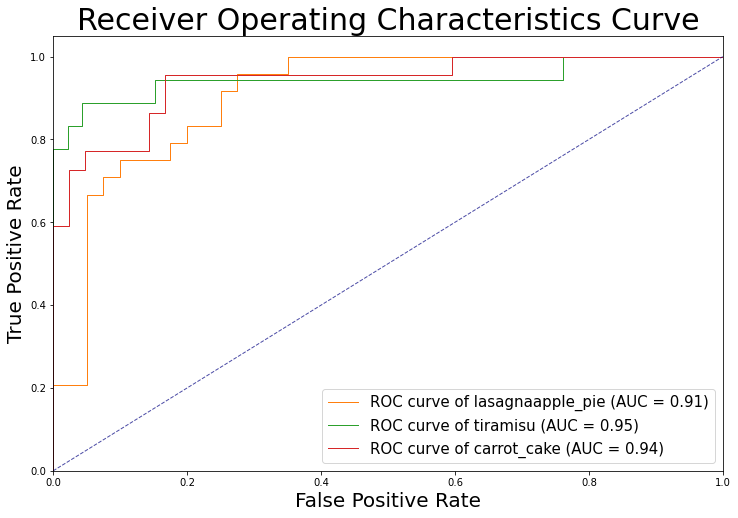

In [13]:
fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under roc curve
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_conf[:, i]) # roc_curve function apply to binary class only
    roc_auc[i] = auc(fpr[i], tpr[i])  # using the trapezoidal rule to get area under curve
classes = list(classtolabel.values())
def plot_roc(fpr,tpr,roc_auc):
    plt.figure(figsize=(12,8))
    plt.plot(fpr[0], tpr[0], color='C1', lw=1, label='ROC curve of '+classes[0]+'apple_pie (AUC = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='C2', lw=1, label='ROC curve of '+classes[1]+' (AUC = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2], color='C3', lw=1, label='ROC curve of '+classes[2]+' (AUC = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--',alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('Receiver Operating Characteristics Curve',fontsize=30)
    plt.legend(loc="lower right",fontsize=15)
    plt.show()

plot_roc(fpr,tpr,roc_auc)

In [14]:
# find the wrong-est label (largest confidence wrong label)
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 5
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                #print(pred_errors[error])
                ax[row,col].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                                      (classtolabel[pred_errors[error]],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error]],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

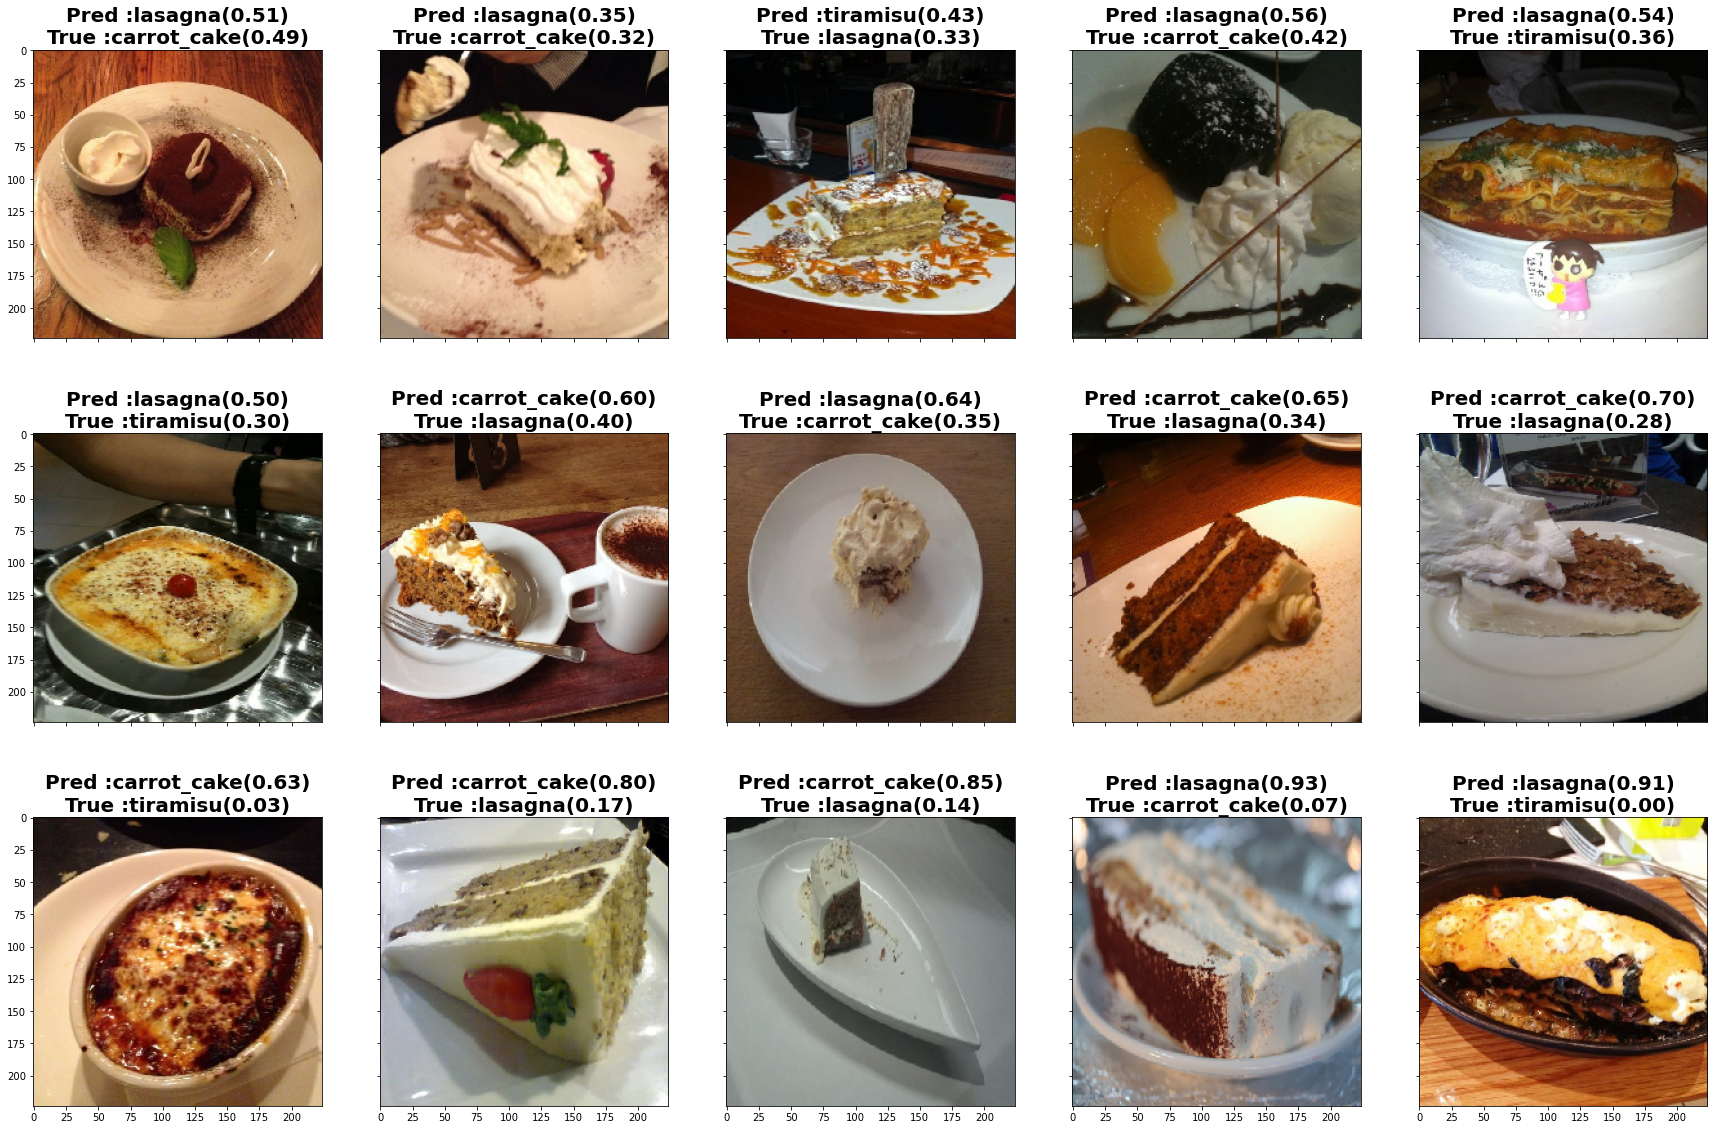

In [15]:
show_wrongest_label(x_test,y_test,y_pred_conf)